In [1]:
import os,sys
sys.path.append('../..')
sys.path.append('../../../gempy/')
import sandbox.sandbox as sb

import gempy as gp
#import gempy_sandbox a   s gpsb
import numpy as np
#from PIL import Image, ImageDraw
import pickle

../../sandbox/sandbox.py:34: RuntimeWarning: Two kernels cannot access the kinect at the same time. This will lead to a sudden death of the kernel. Be sure no other kernel is running before initialize a kinect object.
  'Be sure no other kernel is running before initialize a kinect object.', RuntimeWarning)


### Setup the model gempy model

Now we need to generate the map that we want to poject. In the case of a geological map we will use GemPy.

First we need to load the underlaying 3D model. We can find some examples in the GemPy library

In [2]:
geo_model = gp.load_model_pickle(
    r'data/2_layers.pickle')

/home/miguel/anaconda3/lib/python3.6/site-packages/skcuda/cublas.py:283: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [3]:
geo_model.add_surfaces('rock4')
geo_model.map_series_to_surfaces({'Strat_Series':'rock4'})

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Strat_Series,1,False,#015482,1
1,rock1,Strat_Series,2,False,#9f0052,2
3,rock3,Strat_Series,3,False,#728f02,3
4,rock4,Strat_Series,4,False,#443988,4
2,basement,Basement_Series,1,True,#ffbe00,5


In [4]:
from gempy.core.grid_modules import grid_types
# geo_model.grid.topography = grid_types.Topography(geo_model.grid.regular_grid)
# geo_model.grid.set_active('topography')

# geo_model.add_surfaces('rock3')
# geo_model.map_series_to_surfaces({'Strat_Series': 'rock3'})

In [5]:
#gp.save_model_to_pickle(geo_model,  r'data/2_layers')

In [6]:
#gp.set_interpolation_data(geo_model, theano_optimizer='fast_run')

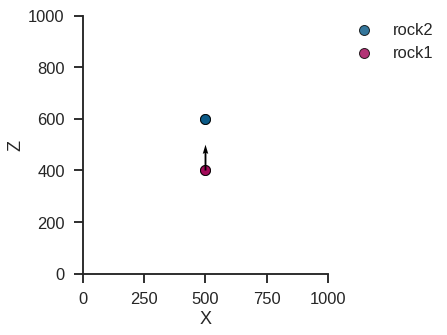

In [7]:
plot_2d = gp.plot.PlotData2D(geo_model)
plot_2d.plot_data()

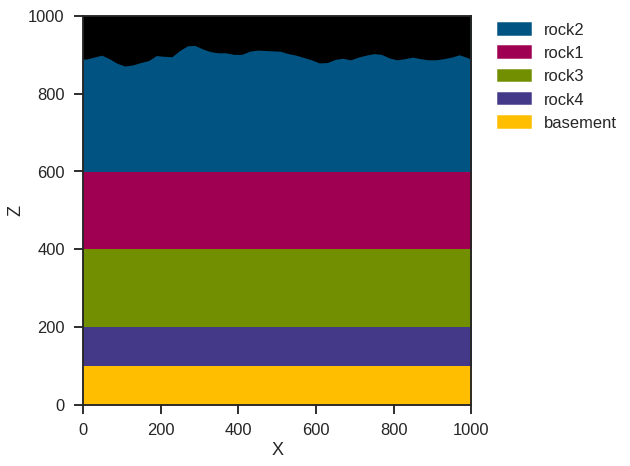

In [28]:
gp.plot.plot_section(geo_model)

In [9]:
gp.compute_model(geo_model)


Lithology ids 
  [3. 3. 3. ... 1. 1. 1.] 

We want to scale the sandbox to the model extent. We can see a gempy model extent by

In [10]:
geo_model.grid.extent

array([   0, 1000,    0, 1000,    0, 1000])

In [11]:
# pass that extent
model_extent = geo_model.grid.extent

### Set up the sandbox 

First we activate the kinect

In [12]:
kinect = sb.Kinect(dummy=False)

looking for kinect...
0
kinect initialized


Now we can set up the projector settings:

In [13]:
projector = sb.Projector(resolution = (1024,768), work_directory='./temp',
                        refresh=100, input_rescale=False)

Next is to pass the calibration---kinect-projector---to the projector class to be able to project just on the sandbox

In [14]:
calibration_filename = "../tutorials/sandbox_bern.dat" 
calibration = sb.Calibration(projector)
calibration.load(calibration_file=calibration_filename)

In [15]:
projector.set_calibration(calibration)
projector.start_stream()   

Also we need to set up the general options of Matplotlib (the library to create the models). Here we are passing the colors of GemPy simply for consistency.

In [19]:
plot_im = sb.Plot(
    calibration=calibration,
    cmap=plot_2d._cmap,
    norm=plot_2d._norm
    )

### Create sandbox grid following the right scale sandbox-model

Now we need to connect the cloud of points recorded by the kinect to the scale of geological model

In [16]:
model_extent = geo_model.grid.regular_grid.extent

scale=sb.Scale(extent=model_extent, calibration=calibration) #initialize scale object to handle the scaling of the model in the andbox
scale.calculate_scales()
grid = sb.Grid(calibration=calibration,scale=scale)

Aspect ratio of the model is fixed in XY
Model size is limited by Y dimension
scale in Model units/ mm (X,Y,Z): [1.3774509803921569, 1.6666666666666667, 1.7857142857142858]
the shown extent is [0.0, 1372.5490196078433, 0.0, 995.0980392156863] 


## Set up digital topography and vtk

In [15]:
# geo_model.grid.topography.values = grid.depth_grid
# geo_model.grid.update_grid_values()
# geo_model.grid.set_active('regular')
# geo_model.grid.set_active('topography')
# geo_model.grid.set_inactive('custom')
# geo_model.grid.active_grids
# geo_model.rescaling.set_rescaled_grid()
# geo_model.update_to_interpolator()
# gp.compute_model(geo_model)

In [25]:
vtk_plot = gp.plot.plot_3D(geo_model)
vtk_plot.set_real_time_on()

holding... Use vtk.resume to go back to the interactive window


### Create the GeoMap module for the Sandbox

To increase the flexibility of the sandbox and generalize the hyperthreading (i.e. getting the sandbox running without blocking python), we have create a modules systems. This modules are classes that encapsulate the specific functionality for each type of map that we want to render. Lets create the geological map module.

In [17]:
projector.work_directory

'./temp'

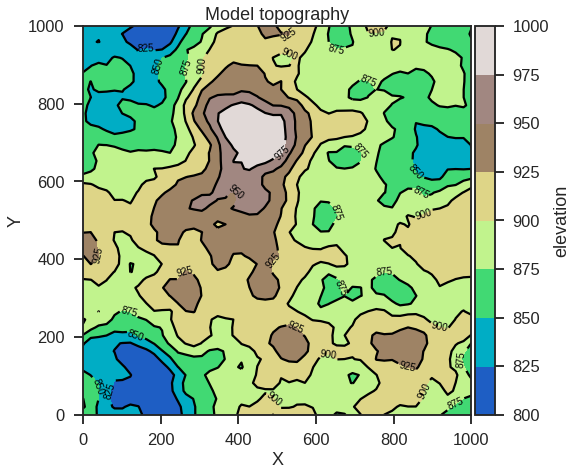

In [20]:
geo_module = sb.GeoMapModule(geo_model, grid, plot_im,
                             work_directory=projector.work_directory)

In [21]:
#r = geo_module.compute_model(kinect.get_filtered_frame())
geo_module.plot_faults = False

### Hyperthreading

In [22]:
s_thread = sb.SandboxThread(geo_module, kinect, projector)

In [23]:
s_thread.run()

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/miguel/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/miguel/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "../../sandbox/sandbox.py", line 1325, in loop
    self.projector.show()
RuntimeError: release unlocked lock



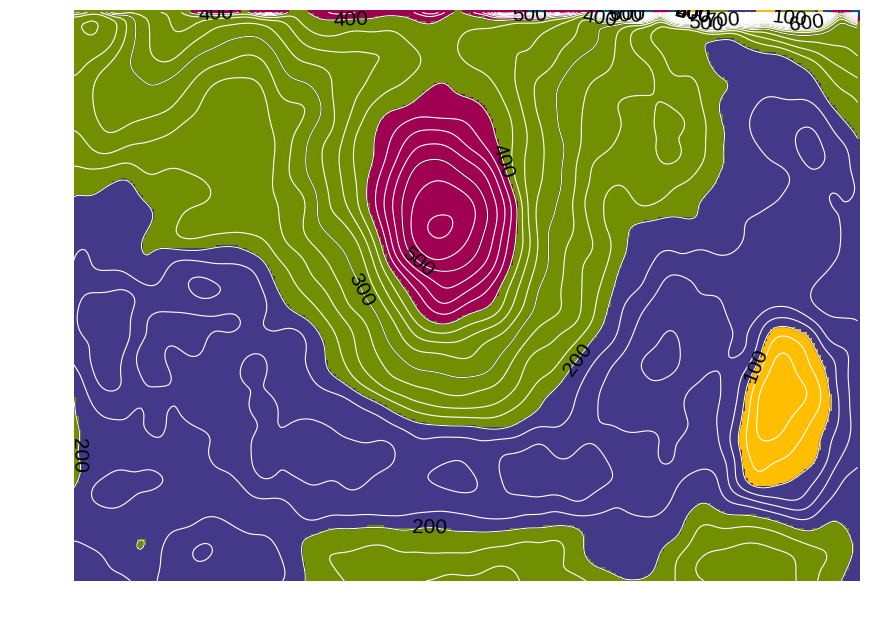

In [77]:
s_thread.kill()

- Change lines in real time
- fault on and off
- change the model

In [27]:
with s_thread.lock:
    geo_module.plot_topography = True

### Topography

In [39]:
with s_thread.lock:
    vtk_plot.render_topography()

In [40]:
with s_thread.lock:
    vtk_plot.set_geological_map()

## Changing the dip

In [39]:
with s_thread.lock:

    geo_model.modify_orientations(1, dip=10,
                                  azimuth=90)
                        #plot_object=vtk_plot)

## Add surface

In [26]:
with s_thread.lock:
    
    geo_model.add_surface_points(600, 600, 100, 'rock3', plot_object=vtk_plot)
    geo_model.add_surface_points(600, 600, 100, 'rock3', plot_object=vtk_plot)

AssertionError: Model not computed. Laking data in some surface


In [31]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,rock2,Strat_Series,1,False,#015482,1
1,rock1,Strat_Series,2,False,#9f0052,2
3,rock3,Strat_Series,3,False,#728f02,3
4,rock4,Strat_Series,4,False,#443988,4
2,basement,Basement_Series,1,True,#ffbe00,5


In [29]:
with s_thread.lock:
    geo_model.delete_surface_points([12, 13], plot_object=vtk_plot)

In [ ]:
vtk_plot.resume()

In [ ]:
vtk_plot.close_window()

In [ ]:
with s_thread.lock:
    geo_model.grid.extent

In [27]:
with s_thread.lock:
    
    geo_model.add_surface_points(700, 700, 200, 'rock4', plot_object=vtk_plot)
    geo_model.add_surface_points(700, 700, 200, 'rock4', plot_object=vtk_plot)

AssertionError: Model not computed. Laking data in some surface


In [49]:
with s_thread.lock:
    geo_model.grid.regular_grid.extent= np.array(
        [0, 1300, 0, 1000, 0, 1000])
    geo_model.grid.extent= np.array(
        [0, 1300, 0, 1000, 0, 1000])
    geo_model.grid.update_grid_values()
    geo_model.rescaling.set_rescaled_grid()

In [29]:
with s_thread.lock:

    scale.extent = np.array(
            [0, 1000, 0, 1000, -100, 900])

### Change model

In [31]:
with s_thread.lock:

    geo_model2 = gp.load_model_pickle('graben.pickle')

In [32]:
gp.compute_model(geo_model2)


Lithology ids 
  [7. 7. 7. ... 3. 3. 3.] 

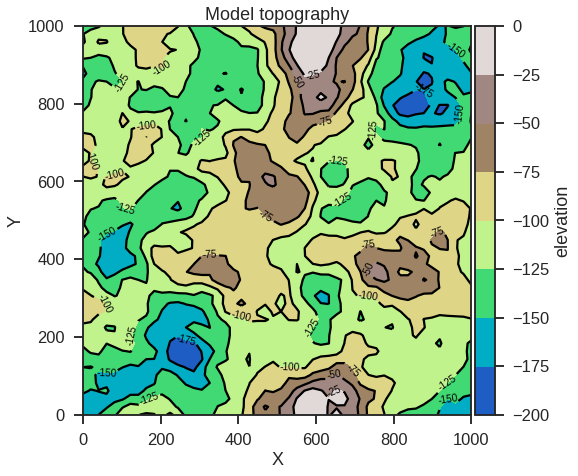

In [33]:
geo_model2.grid.topography = grid_types.Topography(geo_model2.grid.regular_grid)
geo_model2.set_topography('random')

In [40]:
with s_thread.lock:
    geo_module.geo_model = geo_model2

In [41]:
with s_thread.lock:

    scale.extent = np.array(
            [0, 1000, 0, 1000, -800, 200])
    geo_module.plot_topography = False

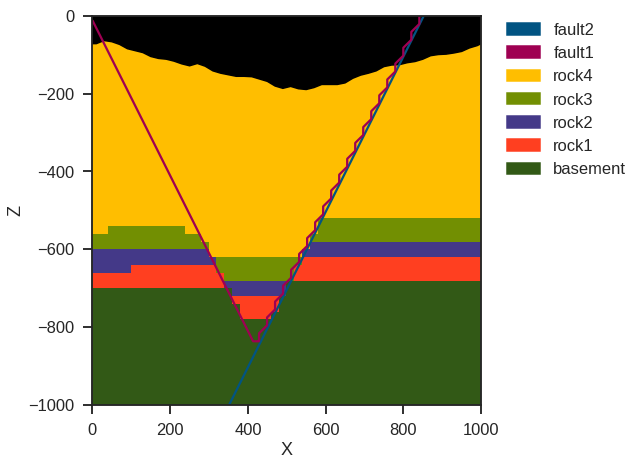

In [51]:
with s_thread.lock:

    gp.plot.plot_section(geo_model2)

## Change model back

In [36]:
with s_thread.lock:
    geo_module.geo_model = geo_model

In [37]:
with s_thread.lock:

    scale.extent = np.array(
            [0, 1000, 0, 1000, 0, 1000])
    geo_module.plot_topography = True

In [42]:
vtk_plot.close_window()

AttributeError: 'GemPyvtkInteract' object has no attribute 'interactor'

In [40]:
vtk_plot = gp.plot.plot_3D(geo_model2)
vtk_plot.set_real_time_on()

AttributeError: 'GemPyvtkInteract' object has no attribute 'topo_visualization'

AttributeError: 'GemPyvtkInteract' object has no attribute 'topo_visualization'

AttributeError: 'GemPyvtkInteract' object has no attribute 'topo_visualization'

In [38]:
vtk_plot.close_window()

### Save geological map

In [ ]:
#with s_thread.lock:
geo_module.export_topographic_map('topographic_map.pdf')

In [ ]:
with s_thread.lock:
    geo_module.export_geological_map(kinect.get_filtered_frame(),
                                     'geological_map.pdf')

### Toggle fault visibility

In [ ]:
geology.pause()
if geology.module.show_faults is True:
    geology.module.show_faults = False
else:
    geology.module.show_faults = True
geology.resume()

## change contour levels 

In [ ]:
#TODO

#        self.fig = plt.figure(figsize=(self.w, self.h), dpi=100, frameon=False)
#         self.ax = plt.Axes(self.fig, [0., 0., 1., 1.])
#         self.ax.set_axis_off()
#         self.fig.add_axes(self.ax)

# geology.pause()
# start = 0
# end = 2000
# main_step = 50
# sub_step = 10

# geology.module.main_contours = np.arange(start, end, main_step)
# geology.module.sub_contours = np.arange(start, end, sub_step)
# geology.resume()

In [ ]:
gp.plot.plot_surfaces_3D(geo_model_3d)
